# Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Analysis & cleansing
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# For cross validation
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn import linear_model, tree, ensemble

# Main Model
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification
from sklearn import metrics

# To Ignore Warnings
import warnings
warnings.filterwarnings('ignore')


# Reading Starcraft Player Dataset 

In [2]:
df = pd.read_csv("starcraft_player_data.csv")
df.head(10)

GameID  LeagueIndex Age HoursPerWeek TotalHours       APM  SelectByHotkeys  \
0      52            5  27           10       3000  143.7180         0.003515   
1      55            5  23           10       5000  129.2322         0.003304   
2      56            4  30           10        200   69.9612         0.001101   
3      57            3  19           20        400  107.6016         0.001034   
4      58            3  32           10        500  122.8908         0.001136   
5      60            2  27            6         70   44.4570         0.000978   
6      61            1  21            8        240   46.9962         0.000820   
7      72            7  17           42      10000  212.6022         0.009040   
8      77            4  20           14       2708  117.4884         0.002944   
9      81            4  18           24        800  155.9856         0.005054   

   AssignToHotkeys  UniqueHotkeys  MinimapAttacks  MinimapRightClicks  \
0         0.000220              7        0.000110            0.000392   
1         0.000259              4        0.000294            0.000432   
2         0.000336              4        0.000294            0.000461   
3         0.000213              1        0.000053            0.000543   
4         0.000327              2        0.000000            0.001329   
5         0.000255              2        0.000000            0.000000   
6         0.000169              6        0.000000            0.000045   
7         0.000676              6        0.001164            0.001253   
8         0.000527              2        0.000019            0.000414   
9         0.000524              8        0.000025            0.000399   

   NumberOfPACs  GapBetweenPACs  ActionLatency  ActionsInPAC  \
0      0.004849         32.6677        40.8673        4.7508   
1      0.004307         32.9194        42.3454        4.8434   
2      0.002926         44.6475        75.3548        4.0430   
3      0.003783         29.2203        53.7352        4.9155   
4      0.002368         22.6885        62.0813        9.3740   
5      0.002425         76.4405        98.7719        3.0965   
6      0.001988         94.0227        90.5311        4.1017   
7      0.004952         24.6117        41.7671        6.6104   
8      0.005399         52.0140        46.4321        3.3746   
9      0.003569         24.4632        52.1538        6.5664   

   TotalMapExplored  WorkersMade  UniqueUnitsMade  ComplexUnitsMade  \
0                28     0.001397                6          0.000000   
1                22     0.001193                5          0.000000   
2                22     0.000745                6          0.000000   
3                19     0.000426                7          0.000000   
4                15     0.001174                4          0.000000   
5                16     0.000372                6          0.000000   
6                15     0.000573                5          0.000000   
7                45     0.002277                9          0.000129   
8                29     0.001035                7          0.000273   
9                27     0.001310                6          0.000000   

   ComplexAbilitiesUsed  
0              0.000000  
1              0.000208  
2              0.000189  
3              0.000384  
4              0.000019  
5              0.000000  
6              0.000000  
7              0.000249  
8              0.000470  
9              0.000000

In [3]:
# Checking the data type and information about data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3395 entries, 0 to 3394
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3395 non-null   int64  
 1   LeagueIndex           3395 non-null   int64  
 2   Age                   3395 non-null   object 
 3   HoursPerWeek          3395 non-null   object 
 4   TotalHours            3395 non-null   object 
 5   APM                   3395 non-null   float64
 6   SelectByHotkeys       3395 non-null   float64
 7   AssignToHotkeys       3395 non-null   float64
 8   UniqueHotkeys         3395 non-null   int64  
 9   MinimapAttacks        3395 non-null   float64
 10  MinimapRightClicks    3395 non-null   float64
 11  NumberOfPACs          3395 non-null   float64
 12  GapBetweenPACs        3395 non-null   float64
 13  ActionLatency         3395 non-null   float64
 14  ActionsInPAC          3395 non-null   float64
 15  TotalMapExplored     

> Based on this, I can see that some of the object columns should be ints. Since it would be an issue to do numerical analysis on strings. "Age, HoursPerWeek, TotalHours" will have to be further examined.
There does not seem to be any Null values but further analysis is needed.

In [4]:
# Checking for number of missing values in each column
df.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

> Although it is listed 0, I am still wary about obj columns: Age, HoursPerWeek, TotalHours 

### Handling the Age, HoursPerWeek & TotalHours

In [5]:
# Checking if there was unwanted characters in the columns [Age, HoursPerWeek, TotalHours] that made it datatpe Obj
columns = ["Age", "HoursPerWeek", "TotalHours"]
for column in columns:
    unique_values = df[column].unique()
    print(column, unique_values)

Age ['27' '23' '30' '19' '32' '21' '17' '20' '18' '16' '26' '38' '28' '25'
 '22' '29' '24' '35' '31' '33' '37' '40' '34' '43' '41' '36' '44' '39' '?']
HoursPerWeek ['10' '20' '6' '8' '42' '14' '24' '16' '4' '12' '30' '28' '70' '2' '56'
 '36' '40' '18' '96' '50' '168' '48' '84' '0' '72' '112' '90' '32' '98'
 '140' '?' '80' '60']
TotalHours ['3000' '5000' '200' '400' '500' '70' '240' '10000' '2708' '800' '6000'
 '190' '350' '1000' '1500' '2000' '120' '1100' '2520' '700' '160' '150'
 '250' '730' '230' '300' '100' '270' '1200' '30' '600' '540' '280' '1600'
 '50' '140' '900' '550' '625' '1300' '450' '750' '612' '180' '770' '720'
 '415' '1800' '2200' '480' '430' '639' '360' '1250' '365' '650' '233'
 '416' '1825' '780' '1260' '315' '10' '312' '110' '1700' '92' '2500'
 '1400' '220' '999' '303' '96' '184' '4000' '420' '60' '2400' '2160' '80'
 '25' '624' '176' '?' '35' '1163' '333' '75' '7' '40' '325' '90' '175'
 '88' '850' '26' '1650' '465' '235' '1350' '460' '848' '256' '130' '1466'
 '670' '71

> There was "?" hidden within these columns. Since these columns were supposed to be numeric (int), I will need to convert it by replacing the "?" as null and handle those.

In [6]:
# Output all data table that contains the question mark
Age_question = df[ df["Age"] == "?"] #
Totalhrs_question = df[ df["TotalHours"] == "?"]
HrsWeek_question = df[ df["HoursPerWeek"] == "?"]

Totalhrs_question 

GameID  LeagueIndex Age HoursPerWeek TotalHours       APM  \
358     1064            5  17           20          ?   94.4724   
1841    5255            5  18            ?          ?  122.2470   
3340   10001            8   ?            ?          ?  189.7404   
3341   10005            8   ?            ?          ?  287.8128   
3342   10006            8   ?            ?          ?  294.0996   
3343   10015            8   ?            ?          ?  274.2552   
3344   10016            8   ?            ?          ?  274.3404   
3345   10017            8   ?            ?          ?  245.8188   
3346   10018            8   ?            ?          ?  211.0722   
3347   10021            8   ?            ?          ?  189.5778   
3348   10022            8   ?            ?          ?  210.5088   
3349   10023            8   ?            ?          ?  248.0118   
3350   10024            8   ?            ?          ?  299.2290   
3351   10025            8   ?            ?          ?  179.9982   
3352   10026            8   ?            ?          ?  340.1982   
3353   10028            8   ?            ?          ?  319.7148   
3354   10029            8   ?            ?          ?  290.5914   
3355   10030            8   ?            ?          ?  275.8632   
3356   10035            8   ?            ?          ?  298.7916   
3357   10036            8   ?            ?          ?  325.1154   
3358   10038            8   ?            ?          ?  146.3892   
3359   10039            8   ?            ?          ?  192.4554   
3360   10041            8   ?            ?          ?  315.6936   
3361   10045            8   ?            ?          ?  203.7726   
3362   10046            8   ?            ?          ?  334.5240   
3363   10047            8   ?            ?          ?  175.5936   
3364   10049            8   ?            ?          ?  252.7206   
3365   10050            8   ?            ?          ?  211.9188   
3366   10051            8   ?            ?          ?  269.8998   
3367   10052            8   ?            ?          ?  190.2396   
3368   10055            8   ?            ?          ?  212.4972   
3369   10059            8   ?            ?          ?  219.3894   
3370   10060            8   ?            ?          ?  230.6694   
3371   10061            8   ?            ?          ?  284.2296   
3372   10062            8   ?            ?          ?  355.3518   
3373   10063            8   ?            ?          ?  364.8504   
3374   10064            8   ?            ?          ?  256.5888   
3375   10065            8   ?            ?          ?  248.4012   
3376   10066            8   ?            ?          ?  251.2284   
3377   10067            8   ?            ?          ?  318.3000   
3378   10068            8   ?            ?          ?  288.9198   
3379   10069            8   ?            ?          ?  313.9080   
3380   10072            8   ?            ?          ?  243.7134   
3381   10073            8   ?            ?          ?  312.9804   
3382   10074            8   ?            ?          ?  313.5762   
3383   10075            8   ?            ?          ?  274.6194   
3384   10076            8   ?            ?          ?  225.0678   
3385   10079            8   ?            ?          ?  254.2188   
3386   10081            8   ?            ?          ?  339.1524   
3387   10082            8   ?            ?          ?  310.0416   
3388   10083            8   ?            ?          ?  288.7608   
3389   10084            8   ?            ?          ?  151.4046   
3390   10089            8   ?            ?          ?  259.6296   
3391   10090            8   ?            ?          ?  314.6700   
3392   10092            8   ?            ?          ?  299.4282   
3393   10094            8   ?            ?          ?  375.8664   
3394   10095            8   ?            ?          ?  348.3576   

      SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  MinimapAttacks  \
358          0.003846         0.000783        

> It seems that all the question marks are within LeagueIndex 8. Depending on the distribution and amount of missing values across leagueindex, will I then decide how to impute those values.

In [7]:
# Assigning columns needed
cols_missing = ["Age", "HoursPerWeek", "TotalHours"]

# Replace '?' as null 
df[cols_missing] = df[cols_missing].apply(lambda x: x.replace("?", np.nan))

# Converting the dtype to numeric
for col in cols_missing:
    df[col] = pd.to_numeric(df[col])

In [8]:
# Checking the amount of missing values
df.isnull().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

> By dividing the sum with the total amount of values (3394). I can see that around 1.6% of the data in each of those columns are missing. 

### Imputing missing values by LeagueIndex

<Axes: xlabel='LeagueIndex', ylabel='Age'>

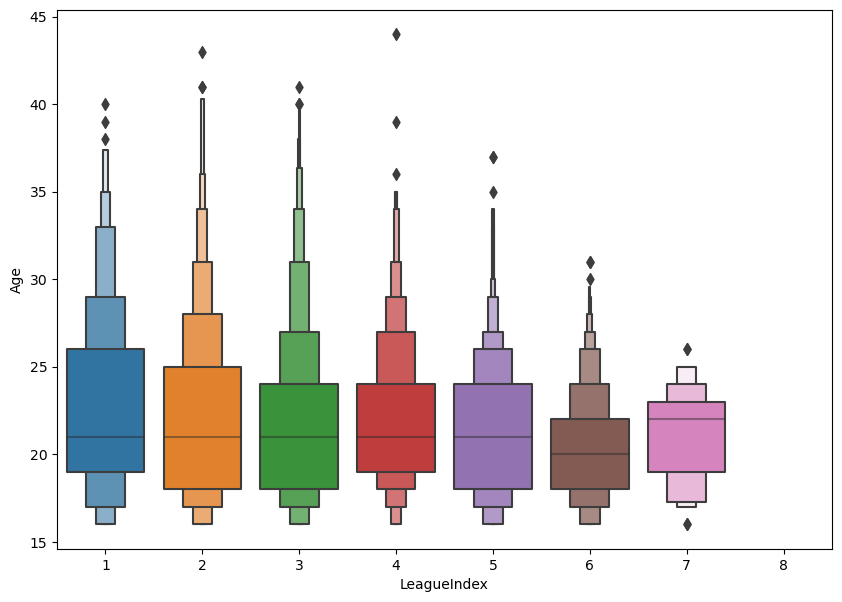

In [9]:
# Visualizing the distribution for Age
plt.figure(figsize=(10, 7))
sns.boxenplot(data=df, x="LeagueIndex", y="Age", k_depth="trustworthy")

> Based on this plot, We can see as the LeagueIndex increases the age decreases. This can be due to multiple factors within younger age groups (Reflex, Consentration, Stamina). So for LeagueIndex 8, we can assume it would be best to replace those nulls with the medians from LeagueIndex 7.

In [10]:
# Replacing Age nulls with median of age from LeagueIndex 7
age_median = df[df["LeagueIndex"] == 7]["Age"].median()
df["Age"] = df["Age"].fillna(age_median)

<Axes: xlabel='LeagueIndex', ylabel='HoursPerWeek'>

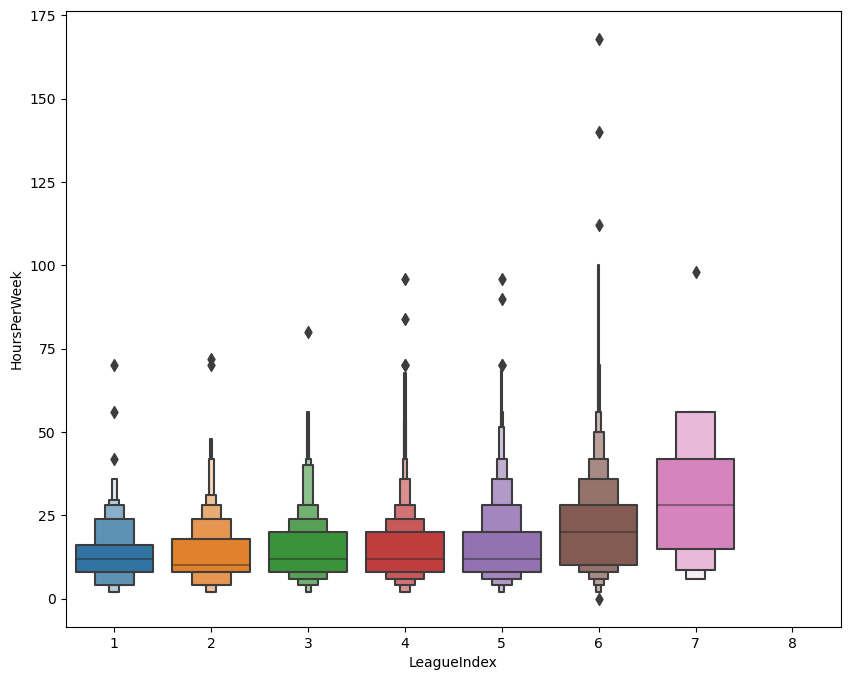

In [11]:
# Visualizing distribution for HoursPerWeek
plt.figure(figsize=(10, 8))
sns.boxenplot(data=df, x="LeagueIndex", y="HoursPerWeek", k_depth="trustworthy")

> It seems that the higher the LeagueIndex the more HoursPerWeek played. So I will similarly do what I did to Age and replace those nulls with the median values from LeagueIndex 7. But as shown from the table with searching for '?', there are values with LeagueIndex 5 that need to be replaced. I will replace those with the medians from its own index.

In [12]:
# Imputing missing values for leagueindex = 5
hrsweek_median5 = df[df["LeagueIndex"] == 5]["HoursPerWeek"].median()
df.loc[(df["HoursPerWeek"].isnull()) & (df["LeagueIndex"] == 5), "HoursPerWeek"] = hrsweek_median5

# Imputing missing value for leagueindex = 8
hrsweek_median7 = df[df["LeagueIndex"] == 7]["HoursPerWeek"].median()
df.loc[(df["HoursPerWeek"].isnull()) & (df["LeagueIndex"] == 8), "HoursPerWeek"] = hrsweek_median7

<Axes: xlabel='LeagueIndex', ylabel='TotalHours'>

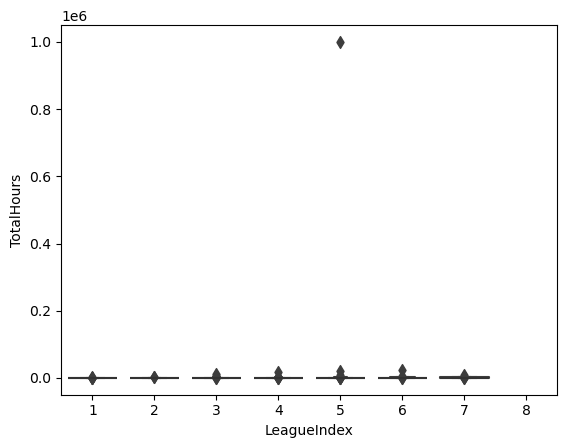

In [13]:
# Visualizing distribution for TotalHours
sns.boxenplot(data=df, x="LeagueIndex", y="TotalHours", k_depth="trustworthy")

> Refering back to the table searching for '?', there is also values in Leagueindex 5 along with 8. Since it is hard to see any differences across the LeagueIndex, I will be using the medians from LeagueIndex 5-7 to fill all the nulls. 

In [14]:
# Getting the medians from LeagueIndex 5-7
totalhrs_median = df[df["LeagueIndex"].between(5, 7)]["TotalHours"].median()
df.loc[df["TotalHours"].isnull(), "TotalHours"] = totalhrs_median 


In [15]:
# Check for nulls after
df.isnull().sum()

GameID                  0
LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

# Exploratory Data Analysis

In [16]:
# Summary stats of updated dataset
df.describe()

GameID  LeagueIndex          Age  HoursPerWeek      TotalHours  \
count   3395.000000  3395.000000  3395.000000   3395.000000     3395.000000   
mean    4805.012371     4.184094    21.653608     16.105449      956.553166   
std     2719.944851     1.517327     4.172356     11.961811    17172.120355   
min       52.000000     1.000000    16.000000      0.000000        3.000000   
25%     2464.500000     3.000000    19.000000      8.000000      300.000000   
50%     4874.000000     4.000000    21.000000     12.000000      500.000000   
75%     7108.500000     5.000000    24.000000     20.000000      800.000000   
max    10095.000000     8.000000    44.000000    168.000000  1000000.000000   

               APM  SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  \
count  3395.000000      3395.000000      3395.000000    3395.000000   
mean    117.046947         0.004299         0.000374       4.364654   
std      51.945291         0.005284         0.000225       2.360333   
min      22.059600         0.000000         0.000000       0.000000   
25%      79.900200         0.001258         0.000204       3.000000   
50%     108.010200         0.002500         0.000353       4.000000   
75%     142.790400         0.005133         0.000499       6.000000   
max     389.831400         0.043088         0.001752      10.000000   

       MinimapAttacks  MinimapRightClicks  NumberOfPACs  GapBetweenPACs  \
count     3395.000000         3395.000000   3395.000000     3395.000000   
mean         0.000098            0.000387      0.003463       40.361562   
std          0.000166            0.000377      0.000992       17.153570   
min          0.000000            0.000000      0.000679        6.666700   
25%          0.000000            0.000140      0.002754       28.957750   
50%          0.000040            0.000281      0.003395       36.723500   
75%          0.000119            0.000514      0.004027       48.290500   
max          0.003019            0.004041      0.007971      237.142900   

       ActionLatency  ActionsInPAC  TotalMapExplored  WorkersMade  \
count    3395.000000   3395.000000       3395.000000  3395.000000   
mean       63.739403      5.272988         22.131664     0.001032   
std        19.238869      1.494835          7.431719     0.000519   
min        24.093600      2.038900          5.000000     0.000077   
25%        50.446600      4.272850         17.000000     0.000683   
50%        60.931800      5.095500         22.000000     0.000905   
75%        73.681300      6.033600         27.000000     0.001259   
max       176.372100     18.558100         58.000000     0.005149   

       UniqueUnitsMade  ComplexUnitsMade  ComplexAbilitiesUsed  
count      3395.000000       3395.000000           3395.000000  
mean          6.534021          0.000059              0.000142  
std           1.857697          0.000111              0.000265  
min           2.000000          0.000000              0.000000  
25%           5.000000          0.000000              0.000000  
50%           6.000000          0.000000              0.000020  
75%           8.000000          0.000086              0.000181  
max          13.000000          0.000902              0.003084

### Box plot to visualize outliers

In [17]:
# Column names with countinous data to visualize
viz_cols = df.drop("LeagueIndex", axis=1).columns

GameID
Skew : -0.01


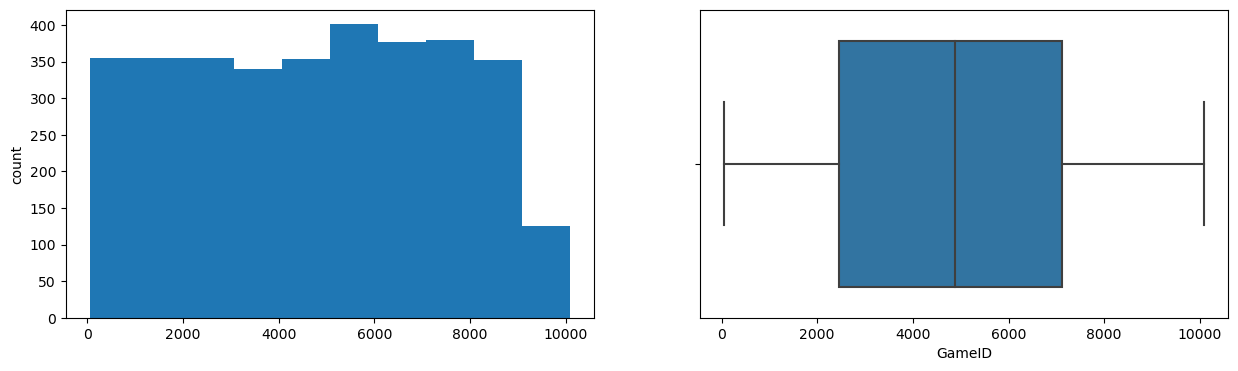

Age
Skew : 1.16


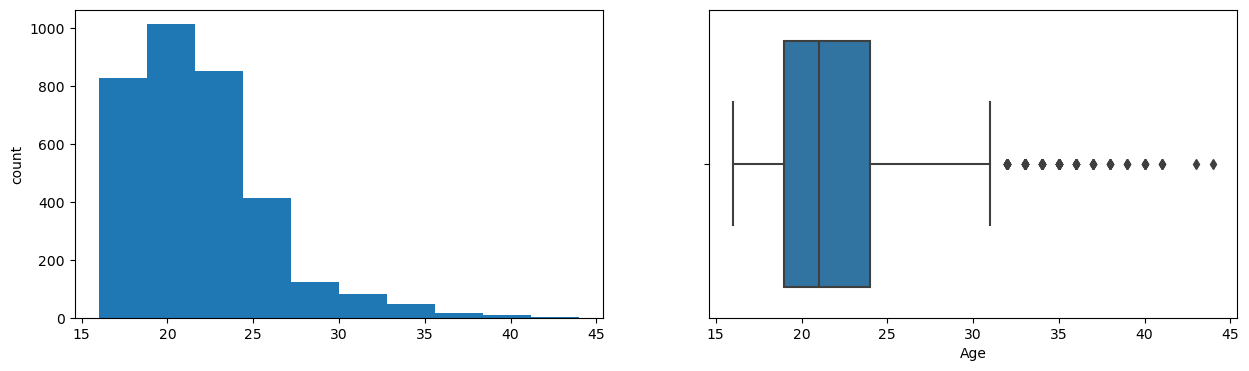

HoursPerWeek
Skew : 2.6


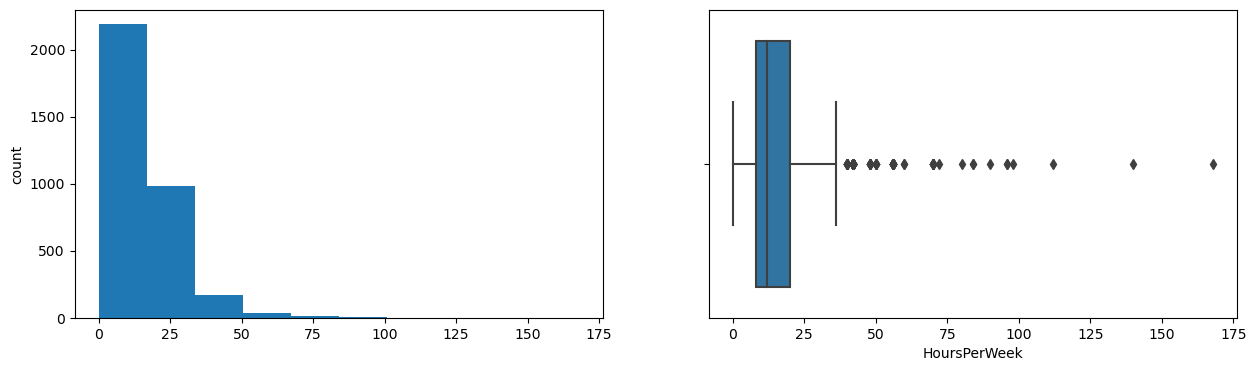

TotalHours
Skew : 58.05


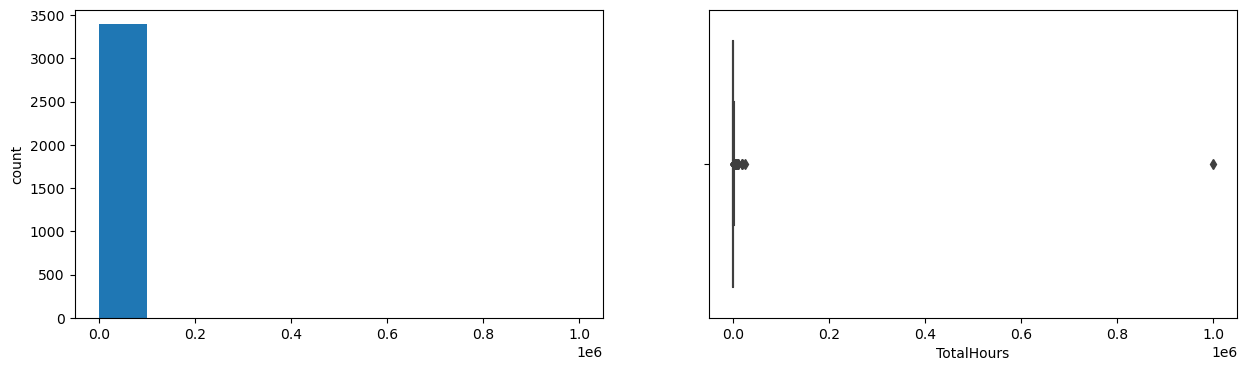

APM
Skew : 1.2


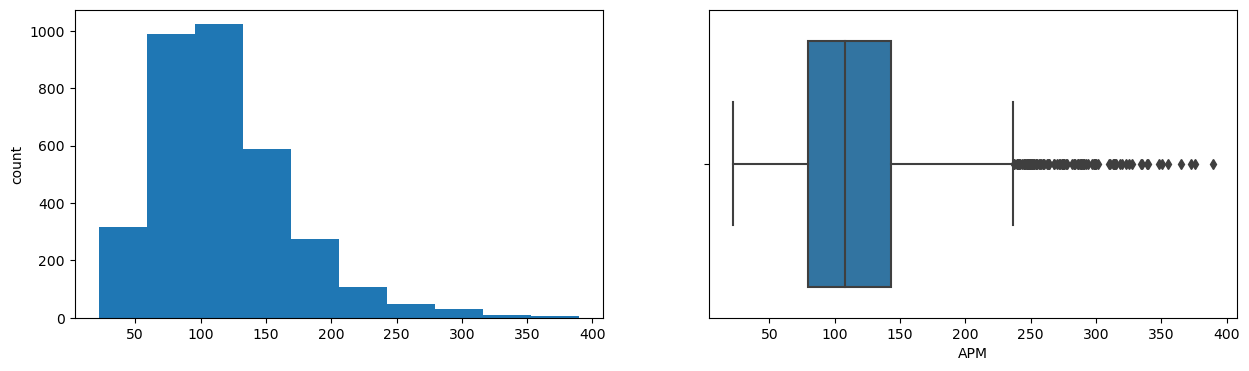

SelectByHotkeys
Skew : 2.97


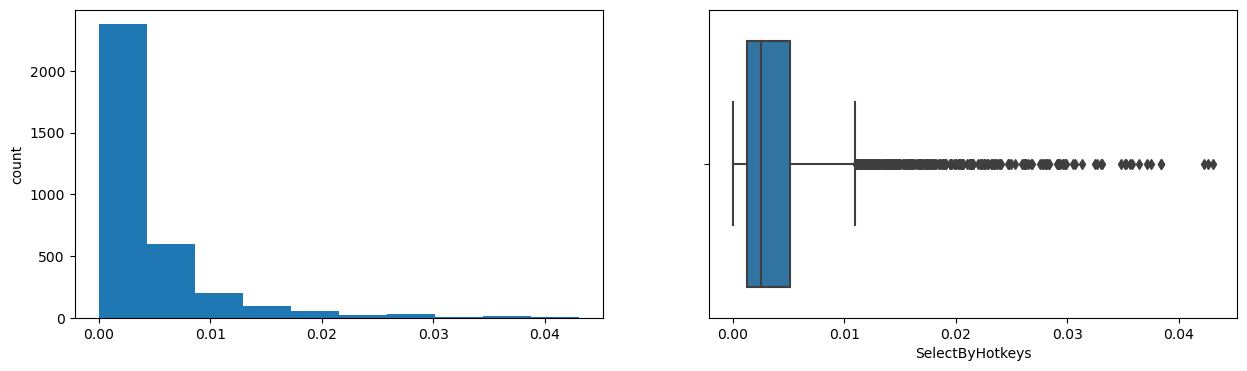

AssignToHotkeys
Skew : 1.14


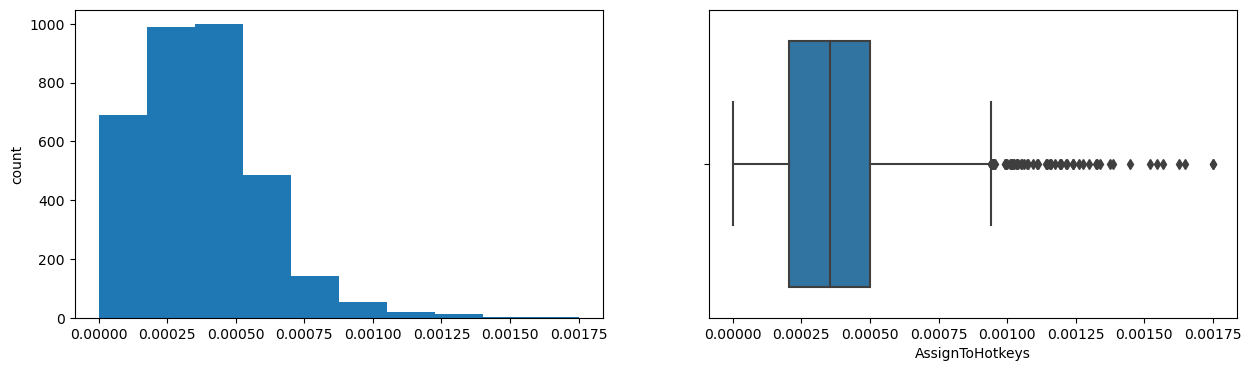

UniqueHotkeys
Skew : 0.21


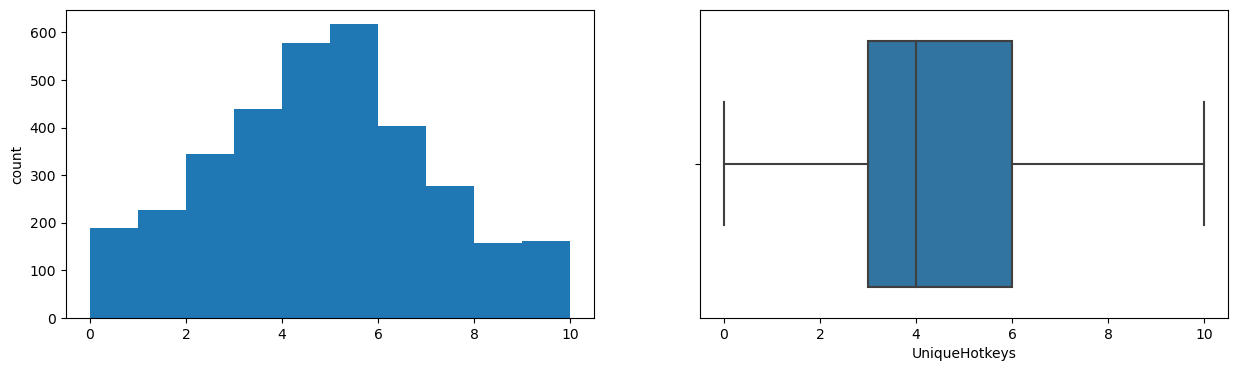

MinimapAttacks
Skew : 4.82


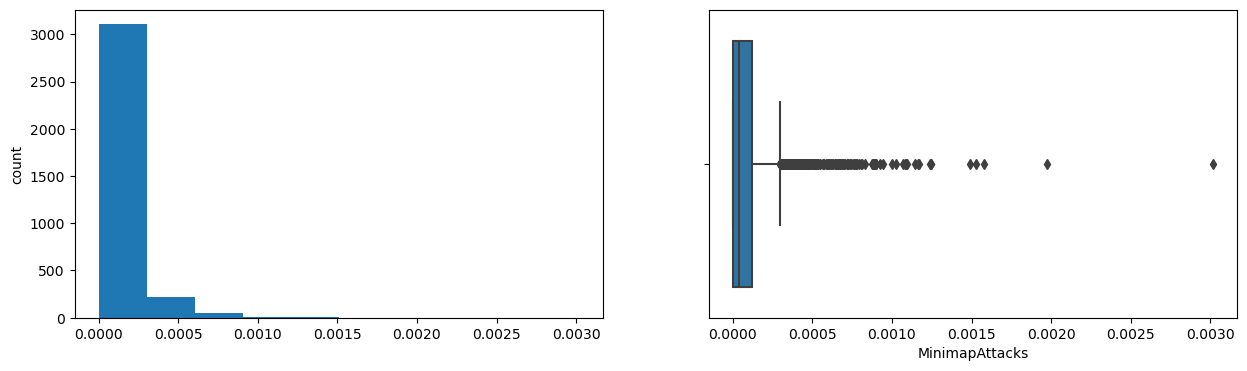

MinimapRightClicks
Skew : 2.56


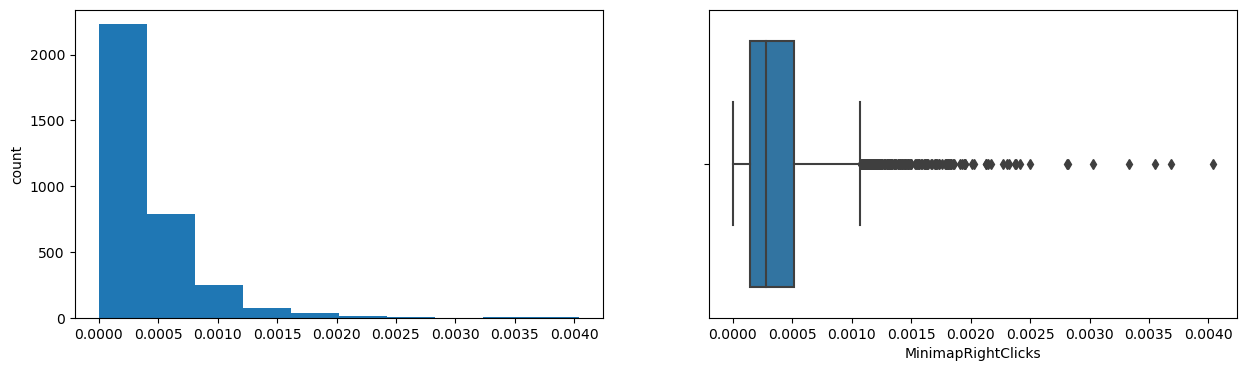

NumberOfPACs
Skew : 0.55


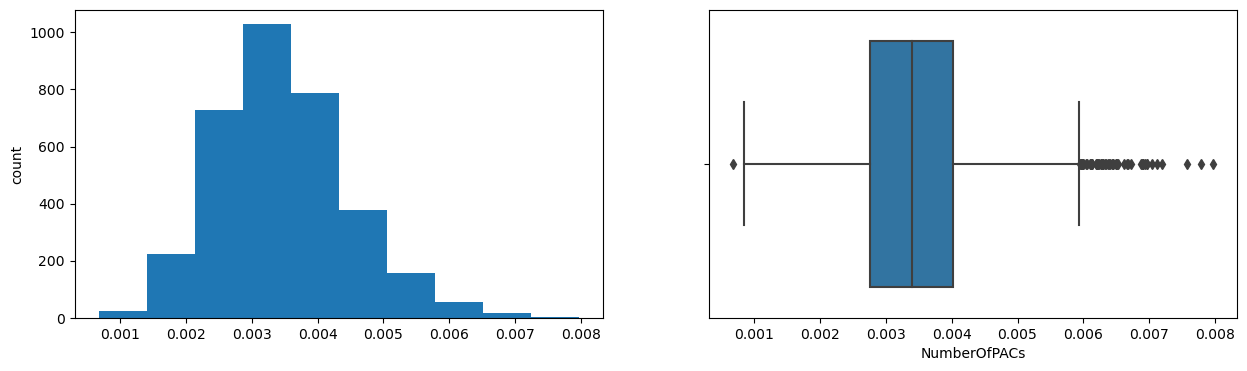

GapBetweenPACs
Skew : 1.91


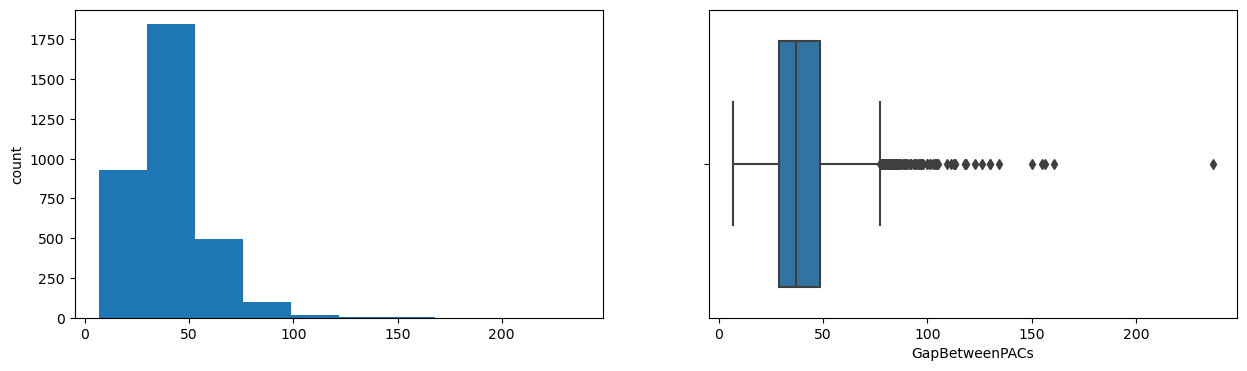

ActionLatency
Skew : 1.15


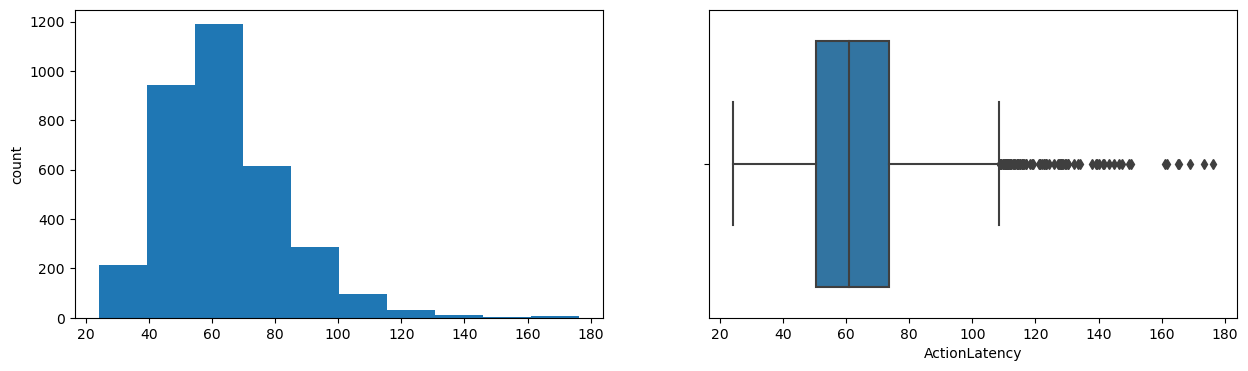

ActionsInPAC
Skew : 1.6


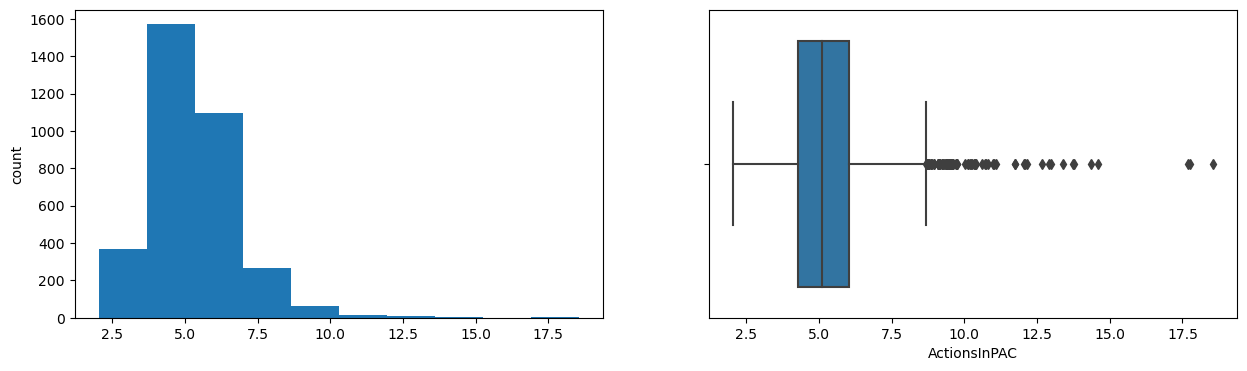

TotalMapExplored
Skew : 0.63


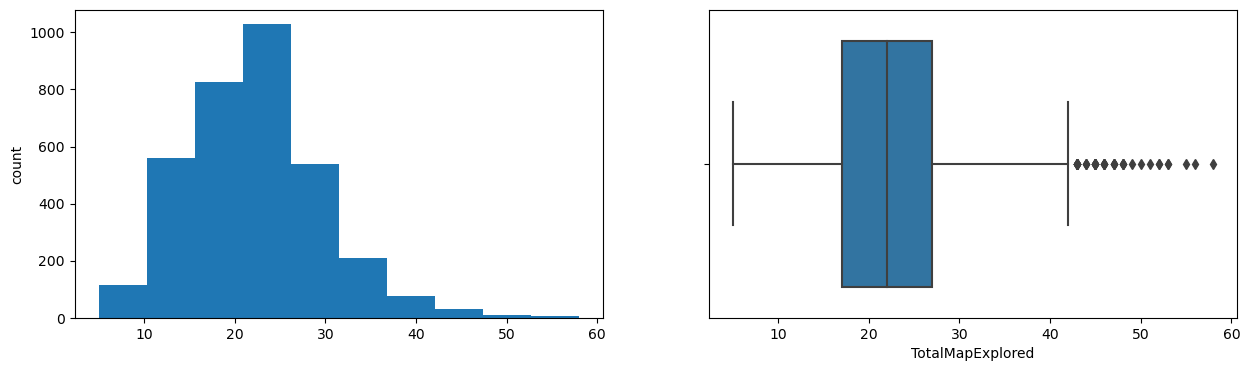

WorkersMade
Skew : 1.66


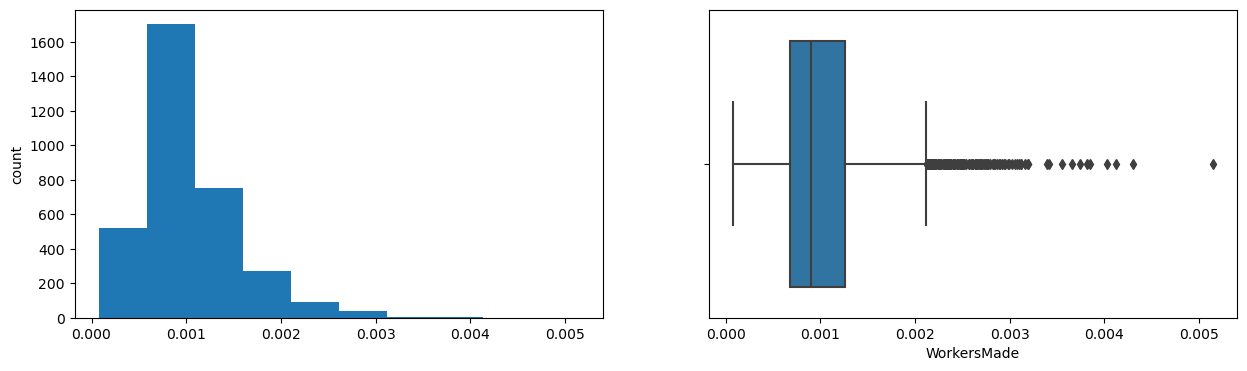

UniqueUnitsMade
Skew : 0.19


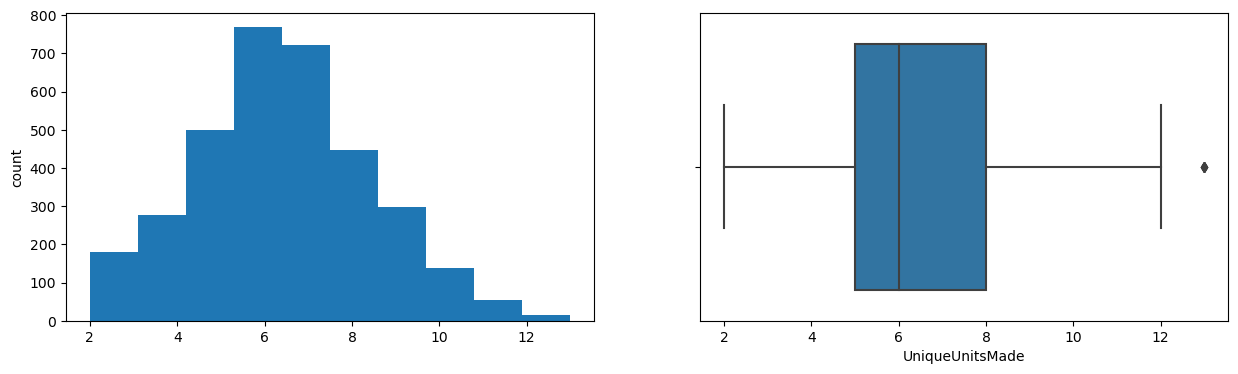

ComplexUnitsMade
Skew : 2.3


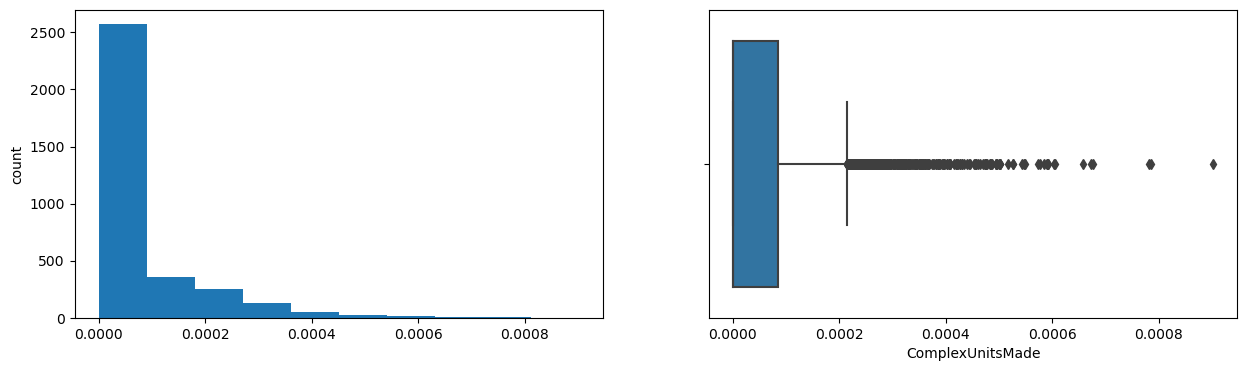

ComplexAbilitiesUsed
Skew : 3.78


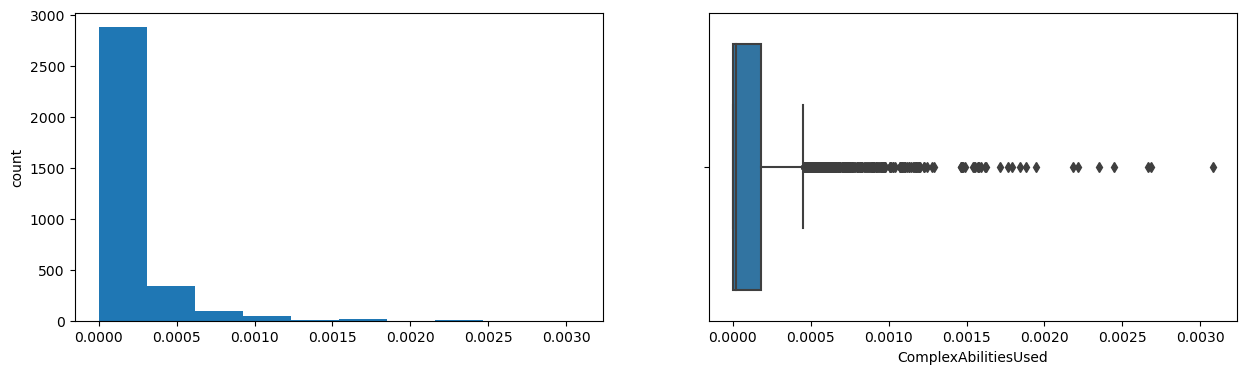

In [18]:
for col in viz_cols:
    print(col)
    print("Skew :", round(df[col].skew(), 2))
    plt.figure(figsize = (15, 4))
    plt.subplot(1, 2, 1)
    df[col].hist(grid=False)
    plt.ylabel("count")
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col])
    plt.show()

> Based on the Box plots and histograms, this reveals that there outliers and positive skews in some features. Further examination should be made to decide if these are true are faulty.

1. I notice immediately when looking at the boxplots and descriptions, there are some features with min: 0. This usually needs to be checked if there is possibility for 0.  

2. Also, for HoursPerWeek the max and outlier value is 168 which divided by 7 is 24 hours a day? (Literally playing 24/7) I believe this is highly immpossible considering a person needs time for sleep/rest/eating. A player will atleast take 7 hours break in a day to do other things besides playing (my assumption based on avg hours of needed sleep). So I will replace all the values greater than 119 as 119. (168-(7 x 7))  

3. Similarly, the max and outlier for TotalHours is 1,000,000. This is 114 years! In order to treat these values, I will calculate the totalhours using the median. I do not know when this data was created so I can't assume based on when the game was released. I can only assume there are some gamers that can play for long periods of time. I will then replace the value greater than 35,000 (apprx. 4 years of playing) with itself. This would need to be checked with more data so that we pass a more accurate value for our model to better predict.

4. Some features are based on players personal attributes so having outliers is possible for skilled individuals, unless it can be verified to report it for treatment.

### Outlier Removal & Handling

In [19]:
# Replacing hoursperweek with values greater than 119 as 119
df.loc[df["HoursPerWeek"] > 119, "HoursPerWeek"] = 119

# Replacing Total hours similarly
df.loc[df["TotalHours"] > 35000, "TotalHours"] = 35000

In [20]:
# Checking updated data
df.describe()

GameID  LeagueIndex          Age  HoursPerWeek    TotalHours  \
count   3395.000000  3395.000000  3395.000000   3395.000000   3395.000000   
mean    4805.012371     4.184094    21.653608     16.084831    672.311635   
std     2719.944851     1.517327     4.172356     11.747460   1033.528052   
min       52.000000     1.000000    16.000000      0.000000      3.000000   
25%     2464.500000     3.000000    19.000000      8.000000    300.000000   
50%     4874.000000     4.000000    21.000000     12.000000    500.000000   
75%     7108.500000     5.000000    24.000000     20.000000    800.000000   
max    10095.000000     8.000000    44.000000    119.000000  35000.000000   

               APM  SelectByHotkeys  AssignToHotkeys  UniqueHotkeys  \
count  3395.000000      3395.000000      3395.000000    3395.000000   
mean    117.046947         0.004299         0.000374       4.364654   
std      51.945291         0.005284         0.000225       2.360333   
min      22.059600         0.000000         0.000000       0.000000   
25%      79.900200         0.001258         0.000204       3.000000   
50%     108.010200         0.002500         0.000353       4.000000   
75%     142.790400         0.005133         0.000499       6.000000   
max     389.831400         0.043088         0.001752      10.000000   

       MinimapAttacks  MinimapRightClicks  NumberOfPACs  GapBetweenPACs  \
count     3395.000000         3395.000000   3395.000000     3395.000000   
mean         0.000098            0.000387      0.003463       40.361562   
std          0.000166            0.000377      0.000992       17.153570   
min          0.000000            0.000000      0.000679        6.666700   
25%          0.000000            0.000140      0.002754       28.957750   
50%          0.000040            0.000281      0.003395       36.723500   
75%          0.000119            0.000514      0.004027       48.290500   
max          0.003019            0.004041      0.007971      237.142900   

       ActionLatency  ActionsInPAC  TotalMapExplored  WorkersMade  \
count    3395.000000   3395.000000       3395.000000  3395.000000   
mean       63.739403      5.272988         22.131664     0.001032   
std        19.238869      1.494835          7.431719     0.000519   
min        24.093600      2.038900          5.000000     0.000077   
25%        50.446600      4.272850         17.000000     0.000683   
50%        60.931800      5.095500         22.000000     0.000905   
75%        73.681300      6.033600         27.000000     0.001259   
max       176.372100     18.558100         58.000000     0.005149   

       UniqueUnitsMade  ComplexUnitsMade  ComplexAbilitiesUsed  
count      3395.000000       3395.000000           3395.000000  
mean          6.534021          0.000059              0.000142  
std           1.857697          0.000111              0.000265  
min           2.000000          0.000000              0.000000  
25%           5.000000          0.000000              0.000000  
50%           6.000000          0.000000              0.000020  
75%           8.000000          0.000086              0.000181  
max          13.000000          0.000902              0.003084

> Furthermore, we can see that there are positively skewed distributions and difference in scale for some features.

In [21]:
# IQR removal method
columns = df.columns

# Define the multiplier for IQR range
iqr_multiplier = 1.5

# Iterate over each column
for col in columns:
    # Calculate the IQR range
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    
    # Upper and lower bounds for removal
    lower_limit = q1 - iqr_multiplier * iqr
    upper_limit = q3 + iqr_multiplier * iqr
    
    # Remove outliers
    cleaned_df = df[(df[col] > lower_limit) & (df[col] < upper_limit)]

# Resets the index so it matches the shape
cleaned_df.reset_index(drop=True, inplace=True)

# Updated DataFrame without outliers
print("Old Shape:", df.shape)
print("New Shape:", cleaned_df.shape)

Old Shape: (3395, 20)
New Shape: (3092, 20)


## Feature Selection & Engineering

In [22]:
# Correlation plot
correlation_matrix = cleaned_df.corr()

# Print the correlation matrix
correlation_matrix

GameID  LeagueIndex       Age  HoursPerWeek  \
GameID                1.000000     0.107599  0.090670      0.012357   
LeagueIndex           0.107599     1.000000 -0.120082      0.243255   
Age                   0.090670    -0.120082  1.000000     -0.190200   
HoursPerWeek          0.012357     0.243255 -0.190200      1.000000   
TotalHours            0.024065     0.215562 -0.034308      0.209146   
APM                   0.162878     0.663648 -0.190621      0.268105   
SelectByHotkeys       0.165879     0.487902 -0.113216      0.226323   
AssignToHotkeys       0.148138     0.520588 -0.092290      0.172025   
UniqueHotkeys         0.132831     0.343890  0.013440      0.080690   
MinimapAttacks        0.070188     0.303567  0.035514      0.103399   
MinimapRightClicks    0.044309     0.230356 -0.013589      0.065642   
NumberOfPACs          0.095978     0.610012 -0.191262      0.186746   
GapBetweenPACs       -0.107032    -0.548142  0.108380     -0.150567   
ActionLatency        -0.094124    -0.672947  0.234781     -0.202874   
ActionsInPAC          0.042223     0.151158 -0.039723      0.107959   
TotalMapExplored      0.036076     0.211818 -0.018246      0.052881   
WorkersMade          -0.016348     0.310994 -0.084044      0.050113   
UniqueUnitsMade       0.028042     0.110864  0.031472      0.022253   
ComplexUnitsMade     -0.035729     0.145974 -0.066974      0.045518   
ComplexAbilitiesUsed -0.026068     0.160364 -0.072869      0.029836   

                      TotalHours       APM  SelectByHotkeys  AssignToHotkeys  \
GameID                  0.024065  0.162878         0.165879         0.148138   
LeagueIndex             0.215562  0.663648         0.487902         0.520588   
Age                    -0.034308 -0.190621        -0.113216        -0.092290   
HoursPerWeek            0.209146  0.268105         0.226323         0.172025   
TotalHours              1.000000  0.234502         0.205903         0.118022   
APM                     0.234502  1.000000         0.835987         0.576059   
SelectByHotkeys         0.205903  0.835987         1.000000         0.504505   
AssignToHotkeys         0.118022  0.576059         0.504505         1.000000   
UniqueHotkeys           0.070668  0.356968         0.301824         0.416742   
MinimapAttacks          0.105145  0.263692         0.177131         0.238345   
MinimapRightClicks      0.071536  0.322183         0.136097         0.189320   
NumberOfPACs            0.160680  0.650456         0.396513         0.477593   
GapBetweenPACs         -0.135256 -0.573648        -0.295265        -0.390230   
ActionLatency          -0.177585 -0.722595        -0.412669        -0.472616   
ActionsInPAC            0.070917  0.391305         0.166592         0.099325   
TotalMapExplored        0.084095  0.216670         0.087386         0.186496   
WorkersMade             0.087801  0.366454         0.155911         0.190768   
UniqueUnitsMade         0.037881  0.079096        -0.002730         0.117523   
ComplexUnitsMade        0.029880  0.109960         0.056379         0.151645   
ComplexAbilitiesUsed    0.030848  0.055689         0.038022         0.182755   

                      UniqueHotkeys  MinimapAttacks  MinimapRightClicks  \
GameID                     0.132831        0.070188            0.044309   
LeagueIndex                0.343890        0.303567            0.230356   
Age                        0.013440        0.035514           -0.013589   
HoursPerWeek               0.080690        0.103399            0.065642   
TotalHours                 0.070668        0.105145            0.071536   
APM                        0.356968        0.263692            0.322183   
SelectByHotkeys            0.301824        0.177131            0.136097   
AssignToHotkeys            0.416742        0.238345            0.189320   
UniqueHotkeys              1.000000        0.179645            0.137783   
MinimapAttacks             0.179645        1.000000            0.234202   
MinimapRightClicks        

There are some features with strong negative and positive correlations. These can be better viewed in a heatmap.

In [23]:
# Correlation based on LeagueIndex
target_correlations = correlation_matrix["LeagueIndex"]
target_correlations

GameID                  0.107599
LeagueIndex             1.000000
Age                    -0.120082
HoursPerWeek            0.243255
TotalHours              0.215562
APM                     0.663648
SelectByHotkeys         0.487902
AssignToHotkeys         0.520588
UniqueHotkeys           0.343890
MinimapAttacks          0.303567
MinimapRightClicks      0.230356
NumberOfPACs            0.610012
GapBetweenPACs         -0.548142
ActionLatency          -0.672947
ActionsInPAC            0.151158
TotalMapExplored        0.211818
WorkersMade             0.310994
UniqueUnitsMade         0.110864
ComplexUnitsMade        0.145974
ComplexAbilitiesUsed    0.160364
Name: LeagueIndex, dtype: float64

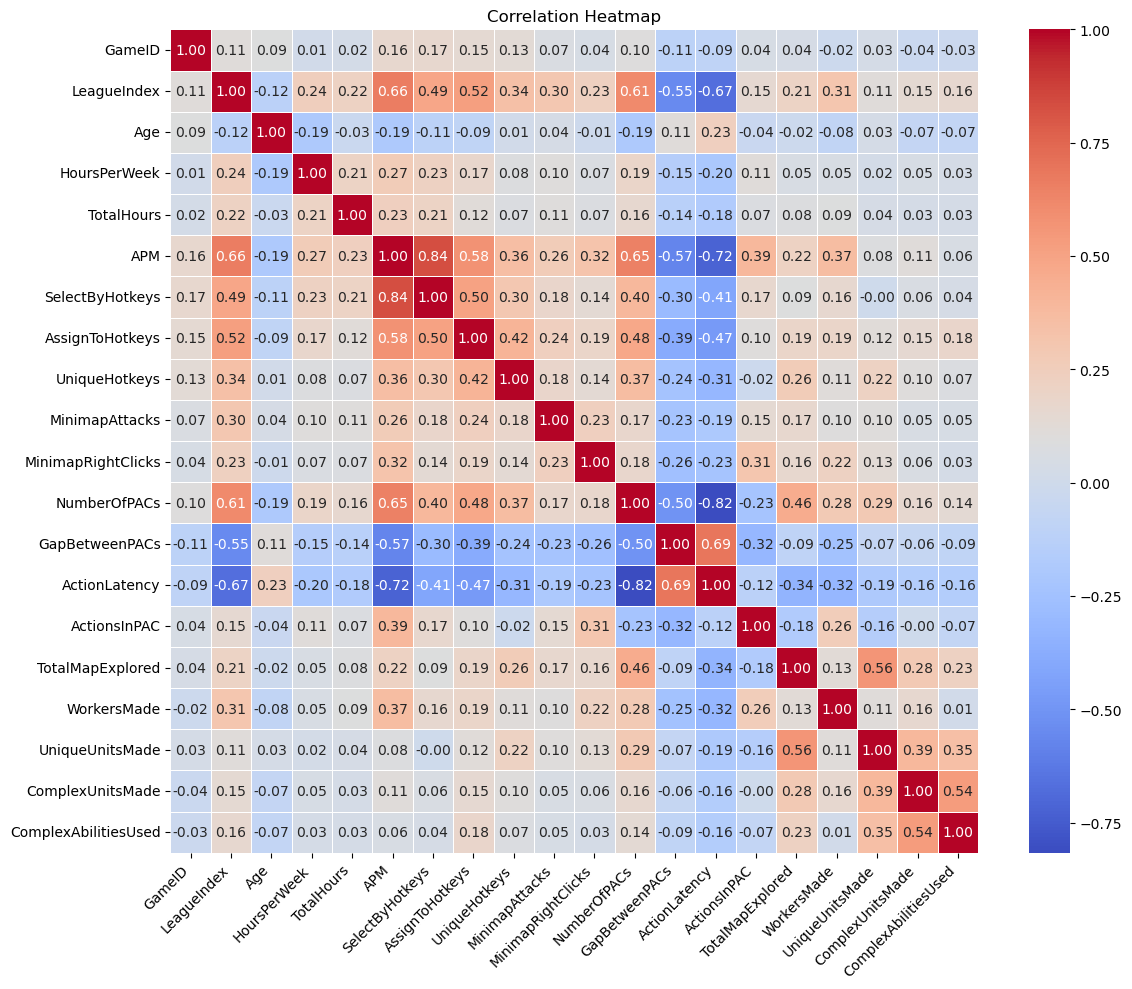

In [24]:
# Heatmap to visualize correlation

# Set the figure size
plt.figure(figsize=(12, 10))

# Customize the heatmap to fit
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# title
plt.title("Correlation Heatmap")

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right")

# Adjust spacing
plt.tight_layout()

plt.show()

> Based on the correlation I would want to look for Multicollinearity in features since those would have a negative impact on our model. Generally looking at anything .5 or less than -.5 is considered as high.
1. I can see that Action Latency, APM, SelectByHotkeys, GapBetweenPacs, AssignToHotkeys are highly correlated to one or another
2. There are some features that could be removed since there is very weak correlation, but further examination would be needed so I do not remove anything that could possibly be useful

### Finding the Variances (VIF)

In [25]:
# Defining the columns 
df_cols = cleaned_df.drop(["LeagueIndex"], axis=1)

# Making new df with VIF values
vif = pd.DataFrame()

vif["feature"] = df_cols.columns

# VIF for each feature
vif["VIF"] = [variance_inflation_factor(df_cols.values, i)
              for i in range(len(df_cols.columns))]

vif

feature         VIF
0                 GameID    4.399933
1                    Age   29.036838
2           HoursPerWeek    3.336173
3             TotalHours    1.518021
4                    APM  222.818793
5        SelectByHotkeys   22.025265
6        AssignToHotkeys    6.436353
7          UniqueHotkeys    5.765210
8         MinimapAttacks    1.558368
9     MinimapRightClicks    2.586031
10          NumberOfPACs   84.164501
11        GapBetweenPACs   14.732179
12         ActionLatency   39.828414
13          ActionsInPAC   65.505724
14      TotalMapExplored   17.614908
15           WorkersMade    6.454343
16       UniqueUnitsMade   22.743556
17      ComplexUnitsMade    1.919238
18  ComplexAbilitiesUsed    2.220332

Looking for VIF >10
1. Removing **ActionsinPAC & UniqueUnitsMade** since in the heatmap they are weakly correlated with our target and has high VIF.
2. Remove **APM** since it has a very high VIF and was correlated to ActionLatency.
4. Remove **SelectByHotkeys, NumberofPACs, GapBetweenPACs , TotalMapExplored**
If there are features that are correlated to eachother, I generally would keep the feature that has a better correlation with LeagueIndex.

In [26]:
# Dropping features with high VIF
df_vif2 = cleaned_df.drop(["LeagueIndex", "ActionsInPAC", "UniqueUnitsMade", "APM", "SelectByHotkeys",
                   "NumberOfPACs", "GapBetweenPACs", "TotalMapExplored"], axis=1,)

vif2 = pd.DataFrame()
vif2["feature"] = df_vif2.columns

# VIF for each feature
vif2["VIF"] = [
    variance_inflation_factor(df_vif2.values, i)
    for i in range(len(df_vif2.columns))
]
vif2.sort_values(["VIF"], ascending=False)

feature        VIF
1                    Age  21.339847
8          ActionLatency  11.979954
5          UniqueHotkeys   5.269272
4        AssignToHotkeys   5.184082
9            WorkersMade   4.954917
0                 GameID   4.237266
2           HoursPerWeek   2.976562
7     MinimapRightClicks   2.262919
11  ComplexAbilitiesUsed   2.078486
10      ComplexUnitsMade   1.799505
6         MinimapAttacks   1.512740
3             TotalHours   1.486356

### Feature Selection

**Age** also is not as significant in information or relationship. When data collecting there are those who also want to keep that information private.
**GameID** is also not significant to predicting the target. Unless it is needed to find a specific player, this could be dealt with later on.

In [27]:
# Droping the features after VIF and correlation analysing 
cols_drop = ["ActionsInPAC", "UniqueUnitsMade", "APM", "SelectByHotkeys", "NumberOfPACs",
             "GapBetweenPACs", "TotalMapExplored", "Age", "GameID"]

New_df = cleaned_df.drop(cols_drop, axis=1)

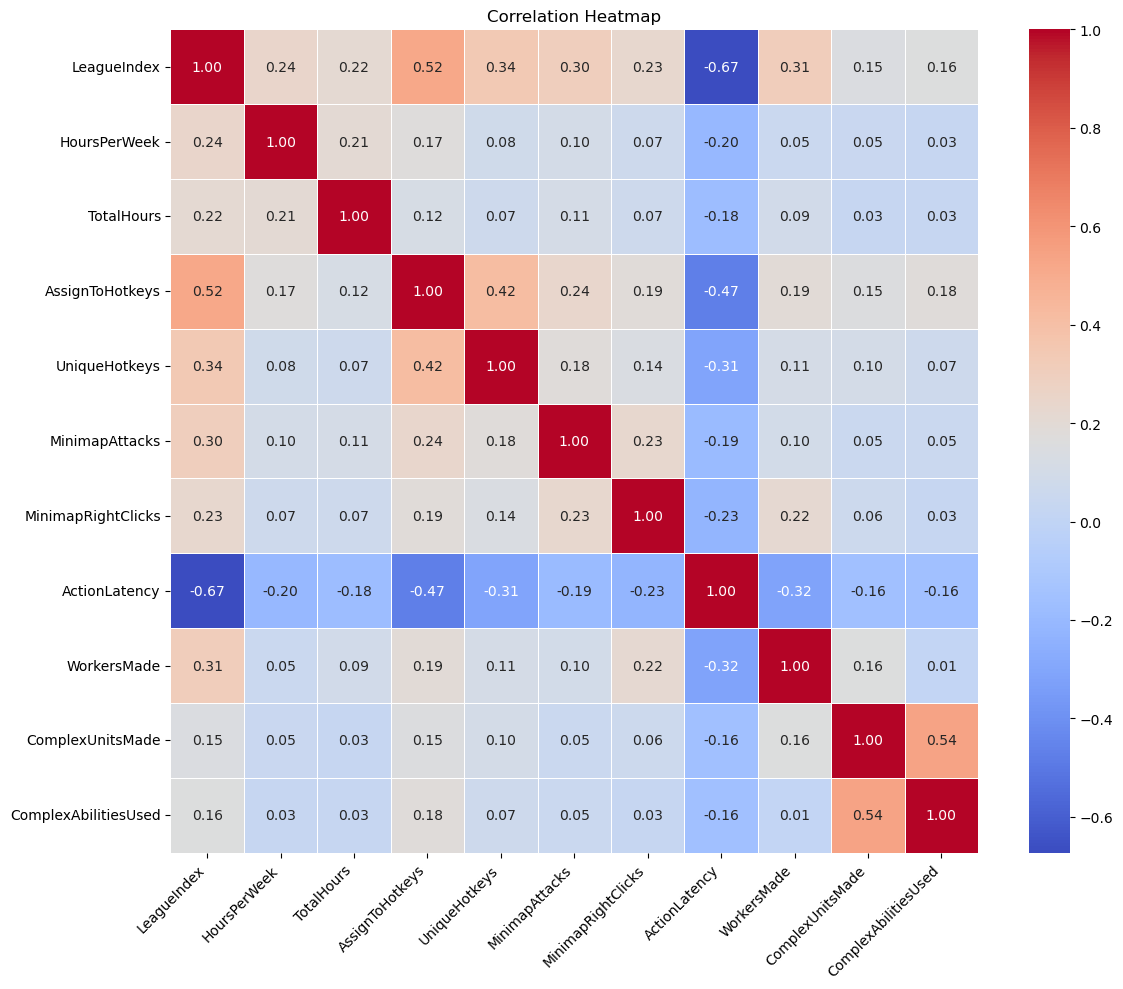

In [28]:
# Heatmap of selected features
corr = New_df.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap")

plt.xticks(rotation=45, ha="right")

plt.tight_layout()

plt.show()

From this heatmap generally values >=0.3 is considered as significant correlation between features.

Correlation Predictions:
- Highest: **Action latency**: Shows that lower the action latency a player has, the less delay and better gameplay, meaning more chances to be playing in higher league.

- High: **AssignToHotKeys**: This implies that having higher number of units/buildings assigned, have more of a chance to play in higher leagues.

- On Threshold: **UniqueHotkeys, Minimapattacks & WorkersMade** are considered strong correlation and can be important for predicting the target.

- Mid-low: **TotalHours, MinimapRightClicks & HoursPerWeek**: based on domain knowledge shows that more time practicing by playing, the better they perform in leagues, which gives more chance to be in higher leagues. Although 

- Low: **ComplexUnitsMade & ComplexAbilitiesUsed** have low correlation and could be considered for removal based on model performance and further examination of importance

In [29]:
# Dropping any final features after
final_drop = ["ComplexUnitsMade", "ComplexAbilitiesUsed"]

final_df = New_df.drop(final_drop, axis=1)

# Modeling

### Output Features (Player Ranks)

In [30]:
# The labels we want to predict
ranks = np.array(final_df["LeagueIndex"])
ranks

array([5, 5, 4, ..., 8, 8, 8], dtype=int64)

### Input Features (Player stats)

In [31]:
# The feature data used for prediction
features = final_df.drop("LeagueIndex", axis=1)

#saving feature names for use
feature_list = list(features.columns)

#Convert to numpy arrays
features = np.array(features)

features

array([[1.0000000e+01, 3.0000000e+03, 2.1969740e-04, ..., 3.9231690e-04,
        4.0867300e+01, 1.3966000e-03],
       [1.0000000e+01, 5.0000000e+03, 2.5946170e-04, ..., 4.3243620e-04,
        4.2345400e+01, 1.1935000e-03],
       [1.0000000e+01, 2.0000000e+02, 3.3557050e-04, ..., 4.6140940e-04,
        7.5354800e+01, 7.4455000e-04],
       ...,
       [2.8000000e+01, 7.3000000e+02, 7.4296010e-04, ..., 1.4615610e-04,
        4.2834200e+01, 8.7694000e-04],
       [2.8000000e+01, 7.3000000e+02, 1.1571794e-03, ..., 1.0833169e-03,
        3.6115600e+01, 7.8787000e-04],
       [2.8000000e+01, 7.3000000e+02, 8.6021510e-04, ..., 1.6897080e-04,
        3.9515600e+01, 1.2596000e-03]])

In [32]:
feature_list

['HoursPerWeek',
 'TotalHours',
 'AssignToHotkeys',
 'UniqueHotkeys',
 'MinimapAttacks',
 'MinimapRightClicks',
 'ActionLatency',
 'WorkersMade']

### Examining data dimensions

In [33]:
ranks.shape

(3092,)

In [34]:
features.shape

(3092, 8)

In [35]:
# The distribution of each target class
class_counts = final_df["LeagueIndex"].value_counts()
class_counts

4    748
5    706
6    548
3    518
2    330
1    164
8     48
7     30
Name: LeagueIndex, dtype: int64

There is a significant class imbalance for league 7-8 compared to the others. This can be also be due to the % of players in each rank, making it already imbalanced. This could be an issue leading to biased models that favor the majority class and perform poorly on the minority class. Depending on the model route I chose, I would need to handle it accordingly.

# Cross Validation

Finding the best model to use

In [36]:
#Model Score using KFold
#The folds are made by preserving the percentages of samples for each class
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

count = 1

for train_index, test_index in kf.split(features,ranks):
    print(f'Fold:{count}, Train set: {len(train_index)},Test set:{len(test_index)}')
    count+=1

Fold:1, Train set: 2319,Test set:773
Fold:2, Train set: 2319,Test set:773
Fold:3, Train set: 2319,Test set:773
Fold:4, Train set: 2319,Test set:773


### Random Forest

In [37]:
score = cross_val_score(ensemble.RandomForestClassifier(random_state= 42), 
                        features, ranks, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.38292367 0.37516171 0.41009056 0.40491591]
Average score: 0.39


### Logistic Regression

In [38]:
score = cross_val_score(linear_model.LogisticRegression(random_state= 42), 
                        features, ranks, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.33247089 0.32082794 0.33505821 0.31435964]
Average score: 0.33


### Decision Tree Classifier

In [39]:
score = cross_val_score(tree.DecisionTreeClassifier(random_state= 42), 
                        features, ranks, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.31435964 0.32988357 0.32082794 0.3156533 ]
Average score: 0.32


## Building Classification Model using Random Forest
Although the scores were low, based on my findings and the problem question, I believe this model would be the best fit due to these factors:
1. Handling complex relationships: There are multiple complex features and relationships to determine a players rank.
2. Handling imbalanced classes: As shown before, there is a clear sample imbalance amongst LeagueIndex 7-8.
3. Handling feature scale: As seen in the dataset there are some features with a much lower scale compared to others.
4. Providing feature importance: This further helps with feature selection and understanding their relationship between ranks.

In [40]:
# Setting up for modeling
clf = RandomForestClassifier(class_weight = "balanced")

##### Splitting the Data for Training and Testing (80/20 ratio)

In [41]:
# 80% of data used for training, 20% is used for testing
X_train, X_test, y_train, y_test = train_test_split(features, ranks, test_size=0.2)

In [42]:
X_train.shape, y_train.shape

((2473, 8), (2473,))

In [43]:
X_test.shape, y_test.shape

((619, 8), (619,))

In [44]:
# Using SMOTE for class imbalance for training data
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [45]:
clf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced')

## Perform predictions on Test Set

### Predicted

In [46]:
y_pred = clf.predict(X_test)
y_pred

array([4, 6, 4, 6, 2, 6, 5, 6, 6, 5, 1, 5, 1, 6, 2, 5, 5, 4, 5, 4, 4, 1,
       6, 5, 5, 2, 3, 2, 2, 5, 2, 6, 1, 3, 6, 6, 2, 5, 6, 4, 4, 4, 3, 4,
       3, 3, 3, 3, 4, 4, 3, 4, 5, 1, 2, 4, 5, 3, 2, 3, 6, 6, 1, 5, 6, 3,
       3, 6, 2, 5, 2, 3, 5, 4, 6, 2, 3, 6, 5, 2, 2, 4, 1, 5, 6, 6, 3, 5,
       4, 4, 6, 6, 3, 4, 4, 1, 4, 4, 6, 7, 2, 3, 5, 6, 2, 6, 6, 6, 3, 5,
       4, 5, 3, 6, 6, 6, 6, 4, 6, 3, 5, 3, 6, 4, 3, 4, 8, 2, 6, 3, 1, 4,
       5, 5, 6, 4, 6, 5, 4, 2, 5, 3, 4, 2, 6, 2, 2, 6, 6, 4, 5, 4, 5, 3,
       2, 6, 1, 5, 5, 5, 2, 1, 6, 2, 4, 6, 3, 5, 5, 6, 2, 5, 5, 4, 5, 5,
       4, 3, 2, 8, 5, 4, 6, 5, 4, 4, 3, 3, 5, 3, 4, 1, 4, 3, 4, 3, 6, 6,
       1, 6, 4, 4, 6, 5, 7, 6, 5, 6, 6, 5, 6, 8, 7, 6, 3, 1, 2, 6, 6, 6,
       2, 6, 5, 1, 6, 5, 1, 4, 4, 6, 3, 6, 2, 5, 6, 6, 3, 4, 5, 2, 1, 3,
       4, 3, 2, 6, 5, 4, 4, 3, 8, 3, 6, 3, 6, 2, 4, 8, 5, 6, 4, 4, 4, 5,
       6, 5, 3, 2, 5, 2, 8, 4, 3, 4, 2, 4, 6, 6, 4, 8, 6, 4, 3, 5, 2, 5,
       1, 5, 6, 2, 4, 5, 2, 4, 5, 1, 6, 4, 1, 5, 2,

### Actual

In [47]:
y_actual = y_test
y_actual

array([2, 6, 4, 6, 2, 6, 3, 6, 6, 6, 2, 6, 1, 6, 2, 6, 5, 2, 6, 4, 5, 2,
       4, 5, 4, 4, 2, 2, 4, 5, 3, 5, 2, 5, 6, 5, 3, 4, 6, 5, 2, 6, 4, 3,
       1, 3, 5, 3, 3, 4, 3, 4, 5, 2, 5, 4, 5, 3, 1, 4, 3, 7, 1, 6, 6, 5,
       4, 2, 3, 5, 3, 3, 4, 6, 8, 5, 4, 6, 5, 4, 2, 4, 4, 4, 6, 6, 3, 5,
       3, 2, 6, 4, 5, 5, 4, 3, 3, 4, 5, 6, 2, 5, 6, 5, 3, 5, 5, 3, 3, 5,
       4, 6, 4, 4, 7, 5, 4, 4, 6, 4, 4, 4, 6, 5, 4, 6, 8, 4, 6, 4, 2, 5,
       6, 5, 5, 5, 3, 4, 3, 3, 3, 4, 4, 4, 6, 3, 4, 5, 5, 6, 5, 5, 3, 4,
       4, 6, 1, 5, 5, 4, 2, 2, 6, 1, 4, 3, 2, 4, 4, 5, 2, 3, 4, 2, 3, 4,
       5, 5, 1, 8, 5, 5, 6, 5, 4, 2, 4, 2, 4, 3, 4, 1, 2, 5, 1, 5, 5, 6,
       1, 5, 3, 3, 6, 3, 6, 5, 6, 6, 5, 5, 5, 8, 6, 6, 5, 2, 3, 6, 6, 5,
       2, 6, 4, 3, 6, 5, 3, 5, 3, 4, 5, 6, 4, 4, 5, 5, 3, 4, 4, 2, 1, 5,
       4, 3, 2, 6, 5, 4, 5, 4, 8, 4, 6, 3, 6, 1, 2, 8, 3, 6, 2, 5, 2, 5,
       4, 4, 4, 3, 4, 4, 8, 5, 1, 3, 3, 3, 6, 6, 3, 8, 6, 3, 5, 4, 1, 4,
       1, 4, 6, 3, 5, 5, 1, 5, 4, 1, 6, 4, 2, 4, 2,

### Model Performance Score

In [48]:
# Printing the prediction acuracy for each test
accuracy = accuracy_score(y_actual, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.3441033925686591


In [49]:
# Report on the model
report = classification_report(y_actual, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           1       0.37      0.38      0.38        34
           2       0.26      0.37      0.30        57
           3       0.34      0.27      0.30       117
           4       0.28      0.25      0.26       149
           5       0.31      0.26      0.28       136
           6       0.46      0.57      0.51       108
           7       0.00      0.00      0.00         4
           8       0.86      0.86      0.86        14

    accuracy                           0.34       619
   macro avg       0.36      0.37      0.36       619
weighted avg       0.34      0.34      0.34       619



Here I can see that predictions for LeagueIndex 8 had the best accuracy. Low f1 score for the other LeagueIndex's could be due to a variety of things and would need to be further examined for training improvements or data improvements.

### Feature Importances

In [50]:
# Shows the feature importances, usually <=0.1 could be examined
# Ordered by respective input feautres. Can adjust features according to results
clf.feature_importances_

array([0.11431705, 0.16400661, 0.13712279, 0.09145633, 0.10689385,
       0.08919772, 0.19509625, 0.1019094 ])

**Hypothetical: after seeing your work, your stakeholders come to you and say that they can collect more data,
but want your guidance before starting. How would you advise them based on your EDA and model results?**

1. Collect more evenly distributed samples across the ranks so there is more accuracy and precision in predicting the higher ranks. 
2. Keep the null values as NaN to be better computed and handled during the cleaning/analysis process. 
3. Look out for false/impossible data (Referencing back to the hours) so these can be avoided in order for the model to fit better accuracy wise
4. Another Feature that could replace Age or add to give more information on LeagueIndexs

**Next Steps and Take Aways:** 

Although I am not as knowledgable in Machine Learning methods, I know I have the work ethic and strong independent learning to get as far as I can in solving the problem. I utilized my skills in UX Design and User research to better analyze the data and find key information. Although I could not fully get to solve the accuracy of my model, I have some ideas to help improve it:

1. Further examining the outliers. Testing the threshold and type of removal. (IQR, Zscore)
2. Possible normalization method for the scale difference. Although it might be needed, could end up being one way towards a solution
3. Log Transformation: As seen in beginning, there were positively skewed data for some of the features.
4. Testing out RFE to determine feature selections. I am new to this one but found it could be a solution. 
5. Possible Training & Testing data handling. I only used the main df all the way down. I could split the Training and testing data earlier on to help better train the model.
6. Further Tuning the model. There are multiple paramaters that could be utilized that I do not know of YET. 

In conclusion, I want to further improve to be able to code more effectively not for myself but for my team. Through this internship I hope to further learn, grow and be curious about the work I do!